In [53]:
import torch
import torchvision
import numpy as np
import cv2
import argparse
from PIL import Image
from torchvision.transforms import transforms as transforms
import os
from pathlib import Path
import matplotlib.pyplot as plt
import random
import os, json, cv2, numpy as np, matplotlib.pyplot as plt
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
# import albumentations as A # Library for augmentations

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.utils as vutils

#Very hacky fix to make matplotlib work on my pc
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
save_dir = repo_dir + "/dev-nbs/saved-labels/"
downloaded_dir = repo_dir + "downloaded-data/"

In [ ]:
   
        if w < 640:
            image = imutils.resize(image, width=640)
        
        boxes = np.array([0, 0, w, h])
        labels = np.zeros((1, 1), dtype=np.float)
        
        target = {}
        target["boxes"] = torch.from_numpy(boxes).type(self.dtype)
        target["labels"] = torch.from_numpy(labels).type(self.dtype)
        target["keypoints"] = torch.from_numpy(kpts).type(self.dtype)
        
        img = T.ToPILImage()(image).convert('RGB')
        img = self.to_tensor(img)        

        return img, target

boxes torch.Size([32, 4])
labels torch.Size([32, 1])
keypoints torch.Size([32, 2, 3])


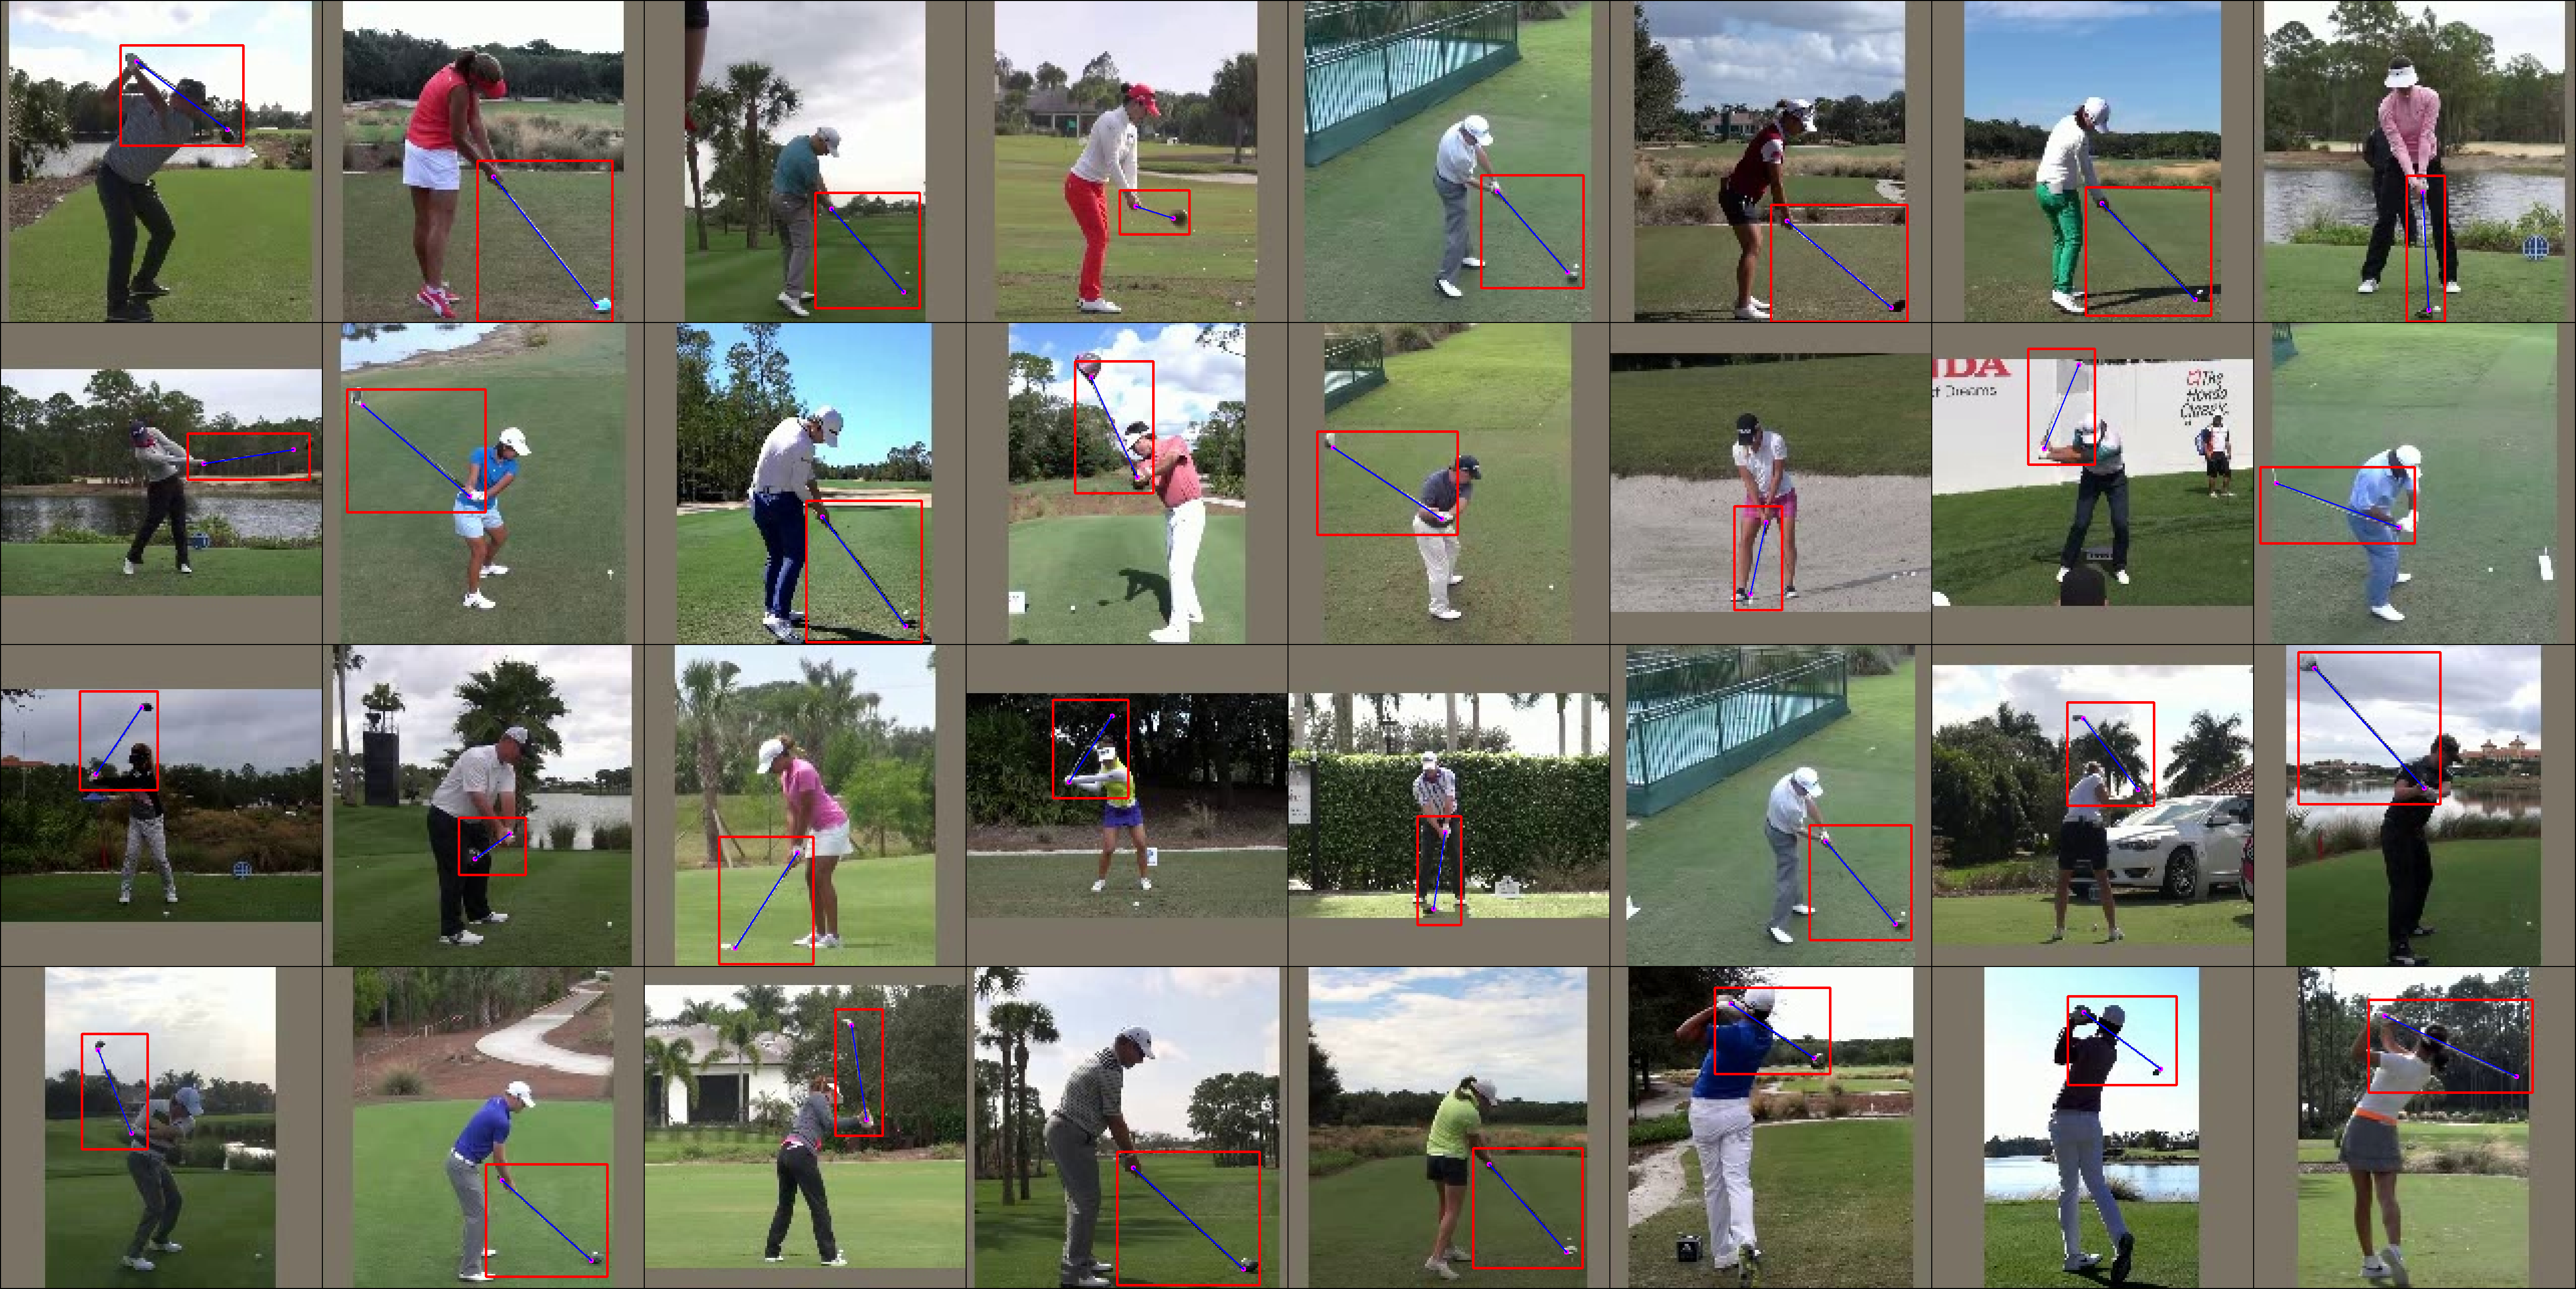

In [102]:
def label_img(img, club_coordinates, box_cords, line_width=4):
    grip, club = club_coordinates
    labelled = img.copy()
    cv2.circle(labelled, grip[:2], 5, (255,0,255), -1)
    cv2.circle(labelled, club[:2], 5, (255,0,255), -1)
    cv2.line(labelled, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(labelled, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return labelled

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, save_dir, annotate = False, resize_size = 640):
        self.save_dir = save_dir
        self.filenames = filenames # filenames of image locations
        self.resize_size = resize_size
        self.dtype = torch.float32
        self.img_transforms = transforms.ToTensor()
        self.annotate = annotate

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_num = int(filename.split("_")[0])
        img = cv2.imread(self.save_dir+filename)
        assert img.shape[0] == img.shape[1], f"Image is not square: {img.shape} | {filename}"

        w = img.shape[0]
        r = self.resize_size / float(w)
        img = cv2.resize(img, (self.resize_size, self.resize_size), interpolation = cv2.INTER_AREA)
        all_cords = [int(x) for x in filename.split("_")[1].split("-")]
        all_cords = [int(x*r) for x in all_cords]
        grip, club, box_cords = all_cords[:2], all_cords[2:4], all_cords[4:]
        grip.append(1.)
        club.append(1.)
        if self.annotate:
            img = label_img(img, [grip, club], box_cords)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        labels = torch.zeros((1, 1))
        
        target = {}
        target["boxes"] = torch.Tensor(box_cords).type(self.dtype)
        target["labels"] = torch.Tensor(1).type(self.dtype)
        target["keypoints"] = torch.Tensor([grip, club]).type(self.dtype)
        
        img = Image.fromarray(img[:,:,::-1])
        img = self.img_transforms(img)      

        return img, target

batch_size = 32
filenames = os.listdir(save_dir)
dataset = GolfDataset(filenames, save_dir, annotate=True, resize_size = 640)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False)
real_batch = next(iter(dataloader))
targets = real_batch[1]
for key in targets.keys():
    print(key, targets[key].shape)
Image.fromarray((vutils.make_grid(real_batch[0], padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))


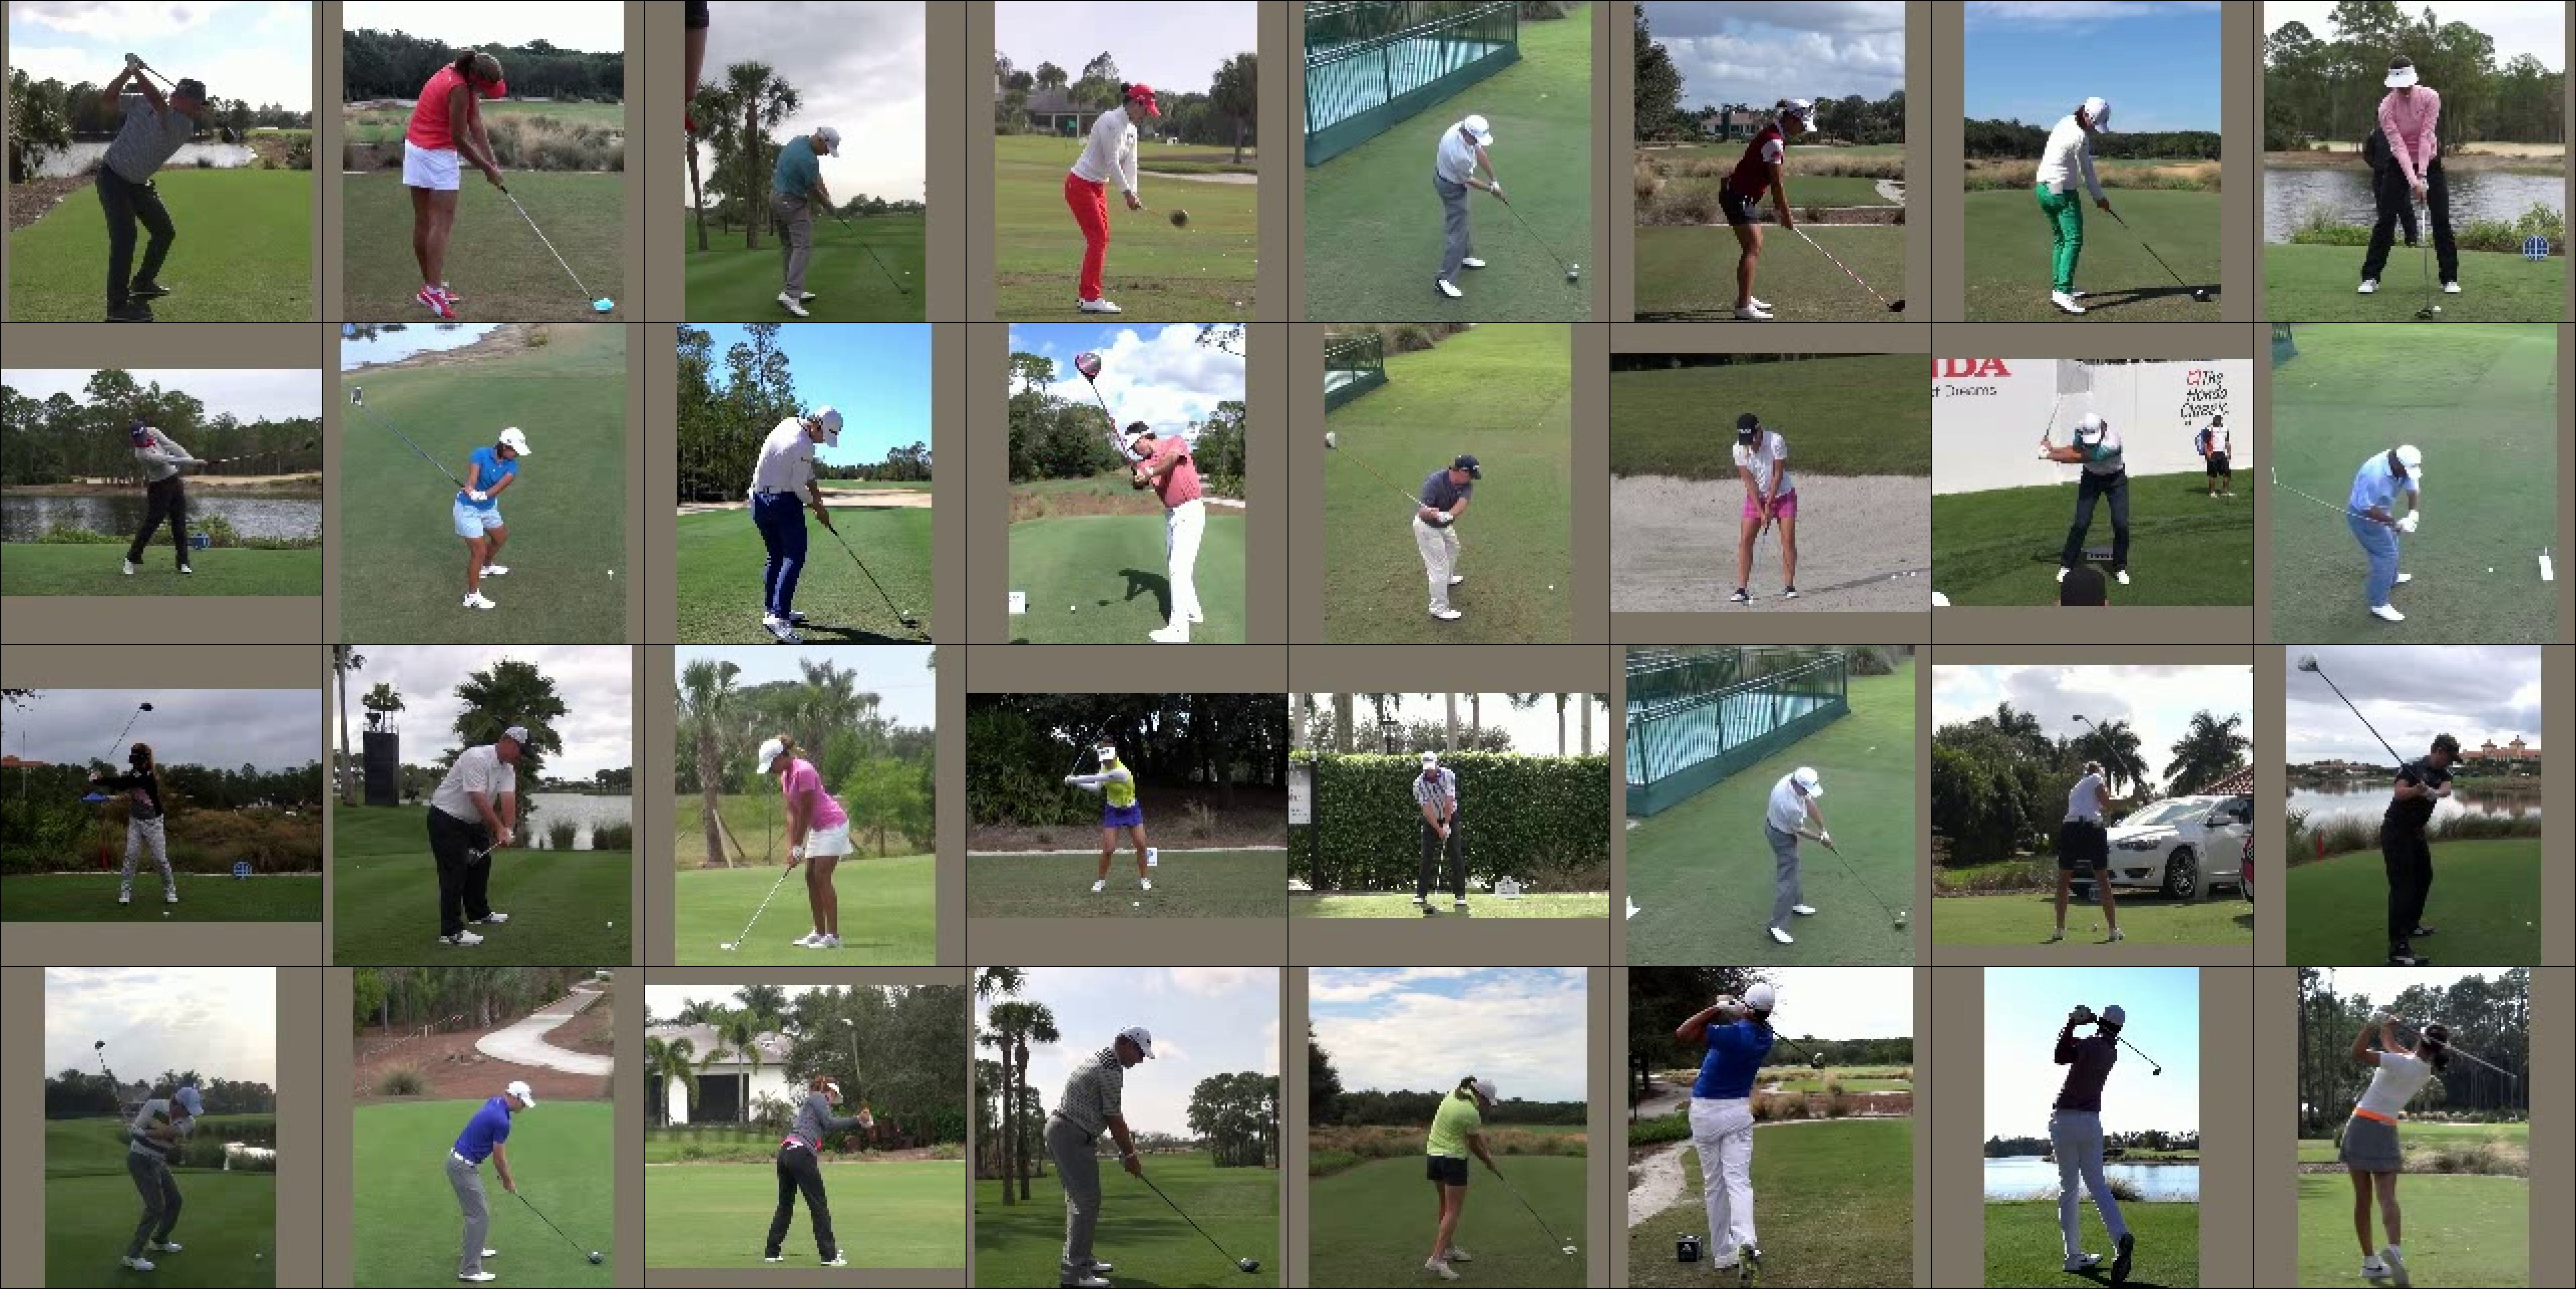

In [80]:
batch_size = 32
filenames = os.listdir(save_dir)
dataset = GolfDataset(filenames, save_dir, resize_size = 640)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False)
real_batch = next(iter(dataloader))
Image.fromarray((vutils.make_grid(real_batch[0], padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

In [91]:
batch = real_batch[0][2:3]
targets = real_batch[1][2:3]
Image.fromarray((vutils.make_grid(batch, padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

TypeError: unhashable type: 'slice'

In [87]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=torchvision.models.detection.KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [88]:
print(batch.shape)
output = model(batch)
output

torch.Size([1, 3, 640, 640])


[{'boxes': tensor([[258.3354, 247.8841, 361.6478, 612.4111],
          [273.2877, 356.8669, 349.1785, 590.7411],
          [385.2974, 426.4194, 401.5475, 444.0718],
          [385.5165, 427.5707, 392.3712, 437.8281],
          [393.0418, 435.6910, 400.0802, 445.2114],
          [396.7185, 439.0126, 403.6216, 447.5129]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.8137, 0.3490, 0.0748, 0.0622, 0.0541, 0.0525],
         grad_fn=<IndexBackward0>),
  'keypoints': tensor([[[357.2769, 293.8497,   1.0000],
           [361.2505, 286.6551,   1.0000],
           [356.4821, 281.8587,   1.0000],
           [331.0514, 272.2659,   1.0000],
           [338.9985, 274.6641,   1.0000],
           [289.7265, 293.0503,   1.0000],
           [321.5149, 300.2449,   1.0000],
           [271.4481, 340.2150,   1.0000],
           [333.4355, 364.9964,   1.0000],
           [350.9192, 391.3767,   1.0000],
           [354.8927, 396.1731,   1.0000],
           [274.6270

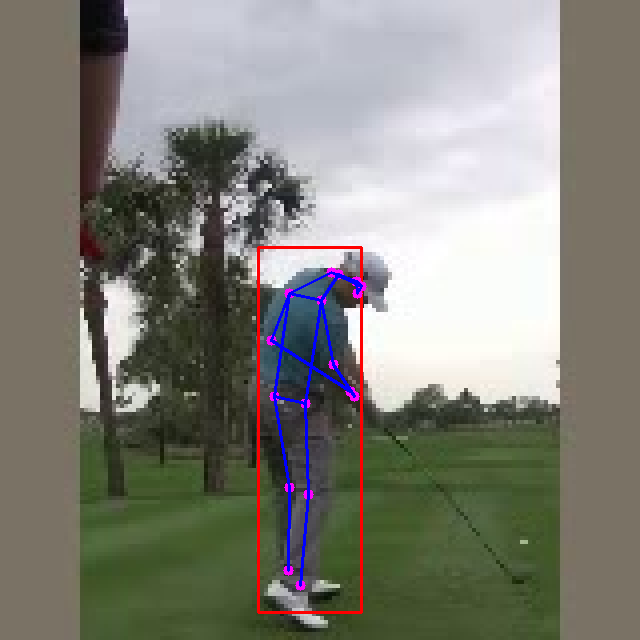

In [90]:
preds = output[0]
input_img = batch[0]
box = [int(x) for x in preds["boxes"][0].detach()]
keypoints = [[int(x[0]), int(x[1])]  for x in preds["keypoints"][0].detach()]
img = (input_img.permute(1,2,0).numpy()*255).astype(np.uint8)[:, :, ::-1]
# Image.fromarray(img[:, :, ::-1])

skeleton =  [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13],[6,7],
            [6,8],[7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]

labelled = img.copy()
cv2.rectangle(labelled, box[:2], box[2:], (0, 0, 255), 2)
for keypoint in keypoints:
    cv2.circle(labelled, tuple(keypoint), 5, (255,0,255), -1)

for pair in skeleton:
    cv2.line(labelled, keypoints[pair[0]-1], keypoints[pair[1]-1], (255, 0, 0), 2)
    
Image.fromarray(labelled[:, :, ::-1])

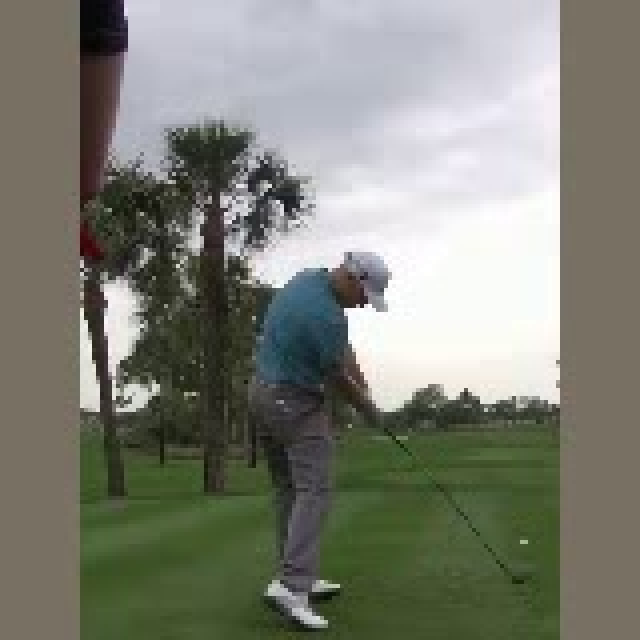

In [109]:
class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, save_dir, annotate = False, resize_size = 640):
        self.save_dir = save_dir
        self.filenames = filenames # filenames of image locations
        self.resize_size = resize_size
        self.img_transforms = transforms.ToTensor()
        self.annotate = annotate

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_num = int(filename.split("_")[0])
        img = cv2.imread(self.save_dir+filename)
        assert img.shape[0] == img.shape[1], f"Image is not square: {img.shape} | {filename}"

        w = img.shape[0]
        r = self.resize_size / float(w)
        img = cv2.resize(img, (self.resize_size, self.resize_size), interpolation = cv2.INTER_AREA)
        all_cords = [int(x) for x in filename.split("_")[1].split("-")]
        all_cords = [int(x*r) for x in all_cords]
        grip, club, box_cords = all_cords[:2], all_cords[2:4], all_cords[4:]
        grip.append(1.)
        club.append(1.)
        if self.annotate:
            img = label_img(img, [grip, club], box_cords)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        labels = torch.zeros((1, 1))
        
        target = {}
        target["boxes"] = torch.Tensor(box_cords).type(torch.FloatTensor)
        target["labels"] = torch.Tensor(1).type(torch.int64)
        target["keypoints"] = torch.Tensor([grip, club]).type(torch.FloatTensor)
        
        img = Image.fromarray(img[:,:,::-1])
        img = self.img_transforms(img)      

        return img, target

batch_size = 1
filenames = os.listdir(save_dir)
dataset = GolfDataset(filenames[2:], save_dir, resize_size = 640)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False)
real_batch = next(iter(dataloader))
Image.fromarray((vutils.make_grid(real_batch[0], padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

In [118]:
targets

{'boxes': tensor([[340., 382., 548., 612.]]),
 'labels': tensor([[0]]),
 'keypoints': tensor([[[372., 414.,   1.],
          [516., 580.,   1.]]])}

In [120]:
images, targets = real_batch
targets['labels'] = targets['labels'][0]
print(images.shape)
print(targets)
model.train()
output = model([images[0]], [targets])

torch.Size([1, 3, 640, 640])
{'boxes': tensor([[340., 382., 548., 612.]]), 'labels': tensor([0]), 'keypoints': tensor([[[372., 414.,   1.],
         [516., 580.,   1.]]])}


In [121]:
output

{'loss_classifier': tensor(0.0595, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0., grad_fn=<DivBackward0>),
 'loss_keypoint': tensor(0., grad_fn=<MulBackward0>),
 'loss_objectness': tensor(0.0967, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0015, grad_fn=<DivBackward0>)}

In [ ]:
for param in model.parameters():
    param.requires_grad = False
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
model.roi_heads.keypoint_predictor.kps_score_lowres = ou
model